In [1]:
#Importa módulos necesarios
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import derivative
import matplotlib.animation as animation
from google.colab import drive
import os
from IPython.display import HTML
from base64 import b64encode

In [2]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/espec_practica/' #Ruta donde trabajar
os.chdir(path);

Mounted at /content/drive


In [3]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

plt.rcParams['lines.markersize'] = 14
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['axes.formatter.use_mathtext'] = True

# Lectura de datos

In [4]:
#Abre el fichero para extraer los datos
f = open('data', 'rb')

#Dimensiones
nt = struct.unpack('i', f.read(4))[0] #Temporal
nl = struct.unpack('i', f.read(4))[0] #Espacial

#Longitud de onda
wave = np.array(struct.unpack('d'*nl, f.read(8*nl))) #[AA]

#Disco
Stokes_0 = np.array(struct.unpack('d'*nl*4, f.read(8*nl*4))).reshape(4, nl)

#Datos
Stokes = np.array(struct.unpack('d'*nl*nt*4, f.read(8*nl*nt*4))).reshape((nt, 4, nl))

#Cierra el fichero
f.close()

# Funciones para plotear y animar

In [5]:
def plot(nrows, ncols, x, y, mrk, xlabels, ylabels, title, name):
    n = nrows * ncols

    if n > 1:
        #Crea figura y subplots
        f, ax = plt.subplots(nrows, ncols, figsize=(14, 10))
        ax = ax.flatten()
        for i in range(n):
            ax[i].plot(x, y[i], mrk, color='mediumpurple', lw = 2)
            ax[i].set_xlabel(xlabels[i])
            ax[i].set_ylabel(ylabels[i])
    else:
        f, ax = plt.subplots(nrows, ncols, figsize=(8, 6))
        ax.plot(x, y, mrk, color='mediumpurple', lw=2)
        ax.set_xlabel(xlabels)
        ax.set_ylabel(ylabels)

    plt.suptitle(title)
    plt.subplots_adjust(wspace=0.25, hspace=0.22, top=0.93)

    plt.savefig(name + '.png', format = 'png')
    plt.show()

    return

In [6]:
def anima(dt_show, nt, x, y, ylim, xlabels, ylabels, title, name):
    #Inicializa el tiempo
    t = 0

    #Crear figura y subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    #Inicializa las líneas para los subplots
    lines = []

    for i, ax in enumerate(axs.flat):
        line, = ax.plot([], [], color='mediumpurple', lw=2)
        ax.set_xlim(x.min(), x.max())
        if i == 0:  #Primer subplot
            ax.set_ylim(ylim[0] * y[:, i, :].min(), ylim[1] * y[:, i, :].max() + 0.002)
        else:
            ax.set_ylim(ylim[0] * y[:, i, :].min(), ylim[1] * y[:, i, :].max())

        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
        lines.append(line)

    #Animación
    def animate(frame):
        nonlocal t
        t = frame  # Actualiza el tiempo actual
        for i, line in enumerate(lines):
            line.set_data(x, y[t, i, :])  # Actualiza los datos
        fig.suptitle(title + r' ($t$ = %.2f)' % (t * dt_show))
        return lines

    #Configura la animación
    ani = animation.FuncAnimation(fig, animate, frames=nt, interval=150, blit=True, repeat=True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.22, top=0.93)

    #Guardar animación
    ani.save(name + '.mp4', writer='ffmpeg', fps=7)

    plt.close(fig)

    return

# Parte 1

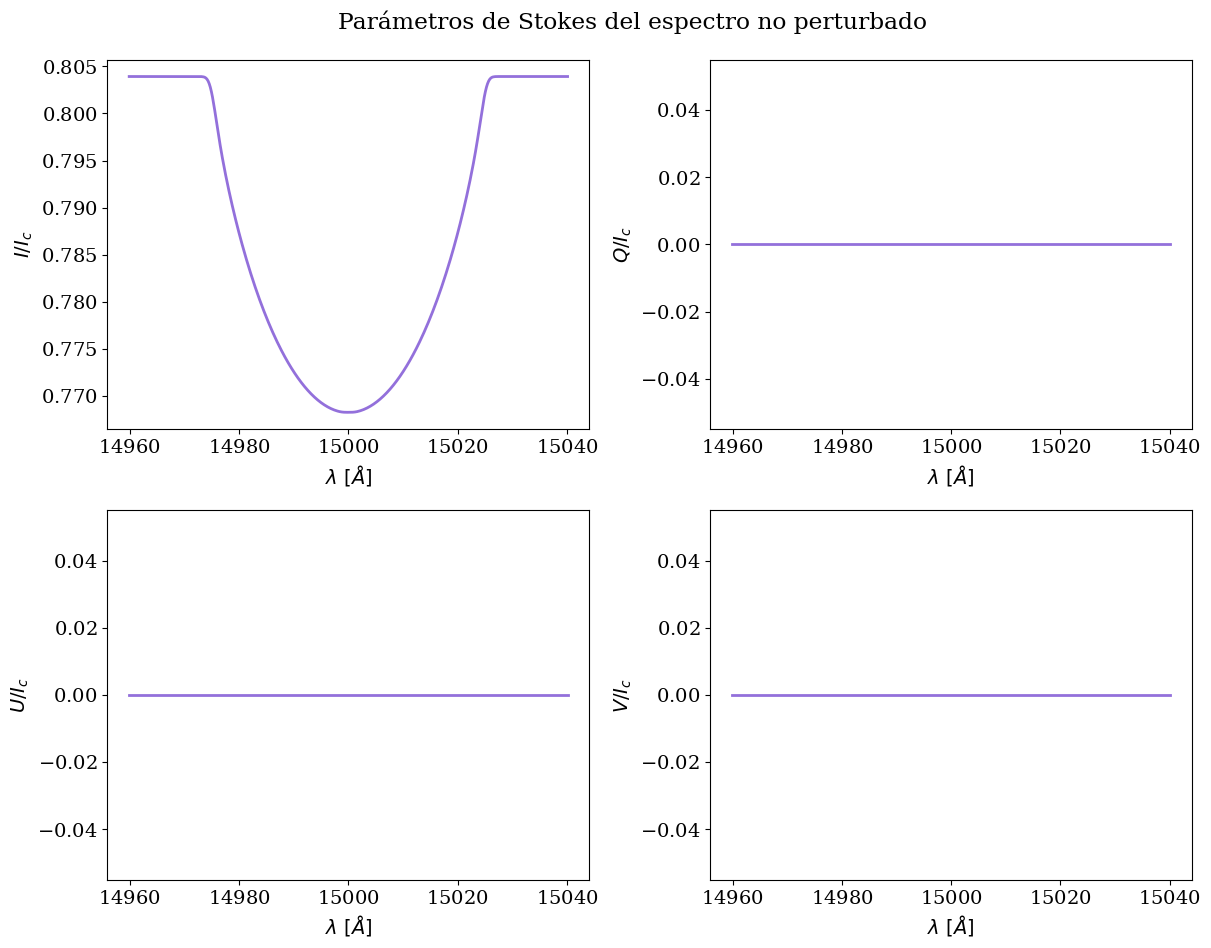

In [ ]:
#Plot de parámetros de Stokes del espectro no perturbado
xlabels = [r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$']
ylabels = [r'$I/I_c$', r'$Q/I_c$', r'$U/I_c$', r'$V/I_c$']

plot(nrows=2, ncols=2, x=wave, y=Stokes_0, mrk='-', xlabels=xlabels, ylabels=ylabels,\
           title=r'Parámetros de Stokes del espectro no perturbado', name='Stokes_0');

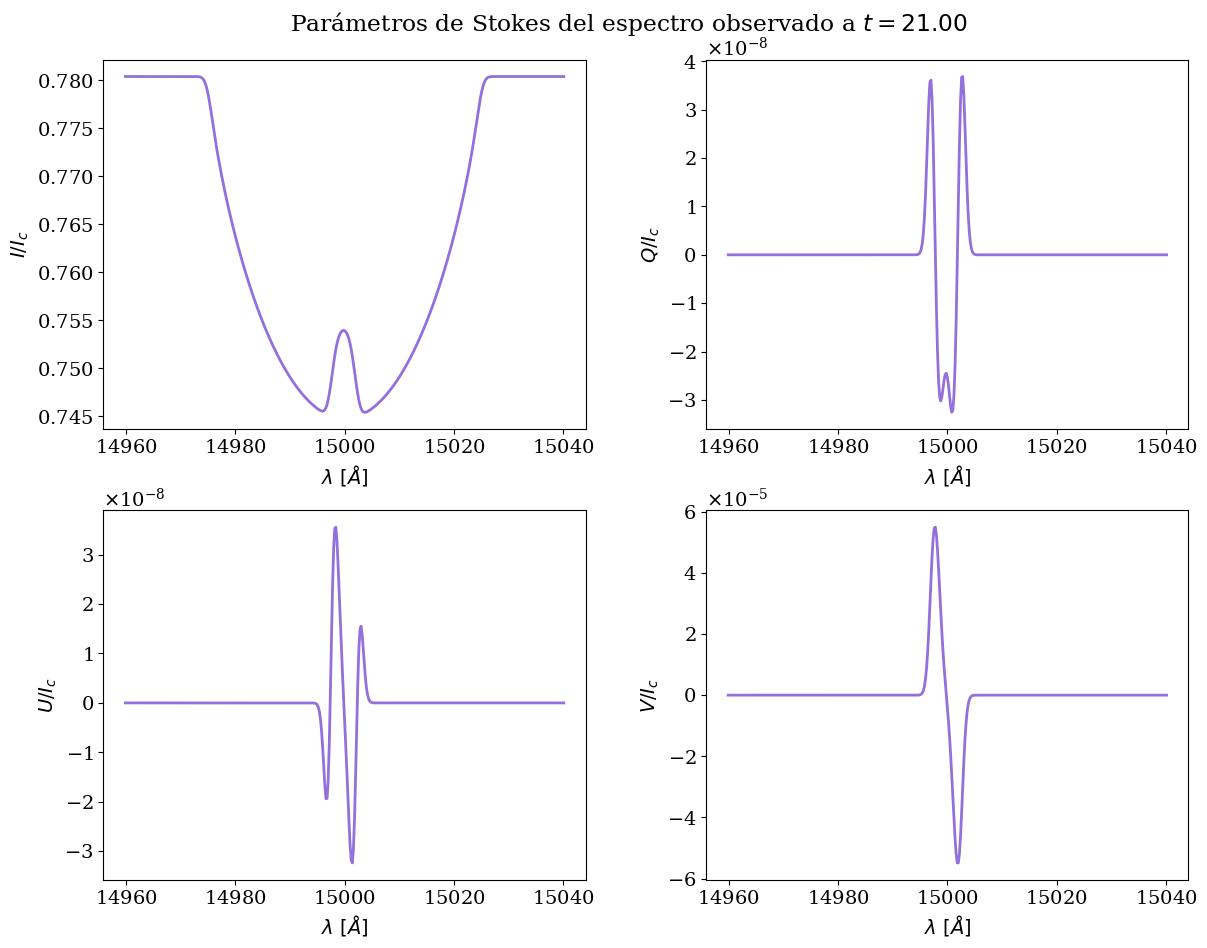

In [ ]:
#Plot de parámetros de Stokes del espectro observado a t = 21
plot(nrows=2, ncols=2, x=wave, y=Stokes[21], mrk='-', xlabels=xlabels, ylabels=ylabels,\
           title=r'Parámetros de Stokes del espectro observado a $t = 21.00$', name='Stokes');

In [ ]:
#Animación de parámetros de Stokes del espectro observado
anima(dt_show=1, nt=nt, x=wave, y=Stokes, ylim=(0.99, 1.05), xlabels=xlabels, ylabels=ylabels, \
            title='Evolución de los parámetros de Stokes del espectro observado', name='Stokes')

In [ ]:
#Mostrar animación
mp4 = open('Stokes.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 height=650 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
#Calcula los parámetros de Stokes del residuo
R = Stokes - Stokes_0 #Resta de datos perturbados y sin perturbar

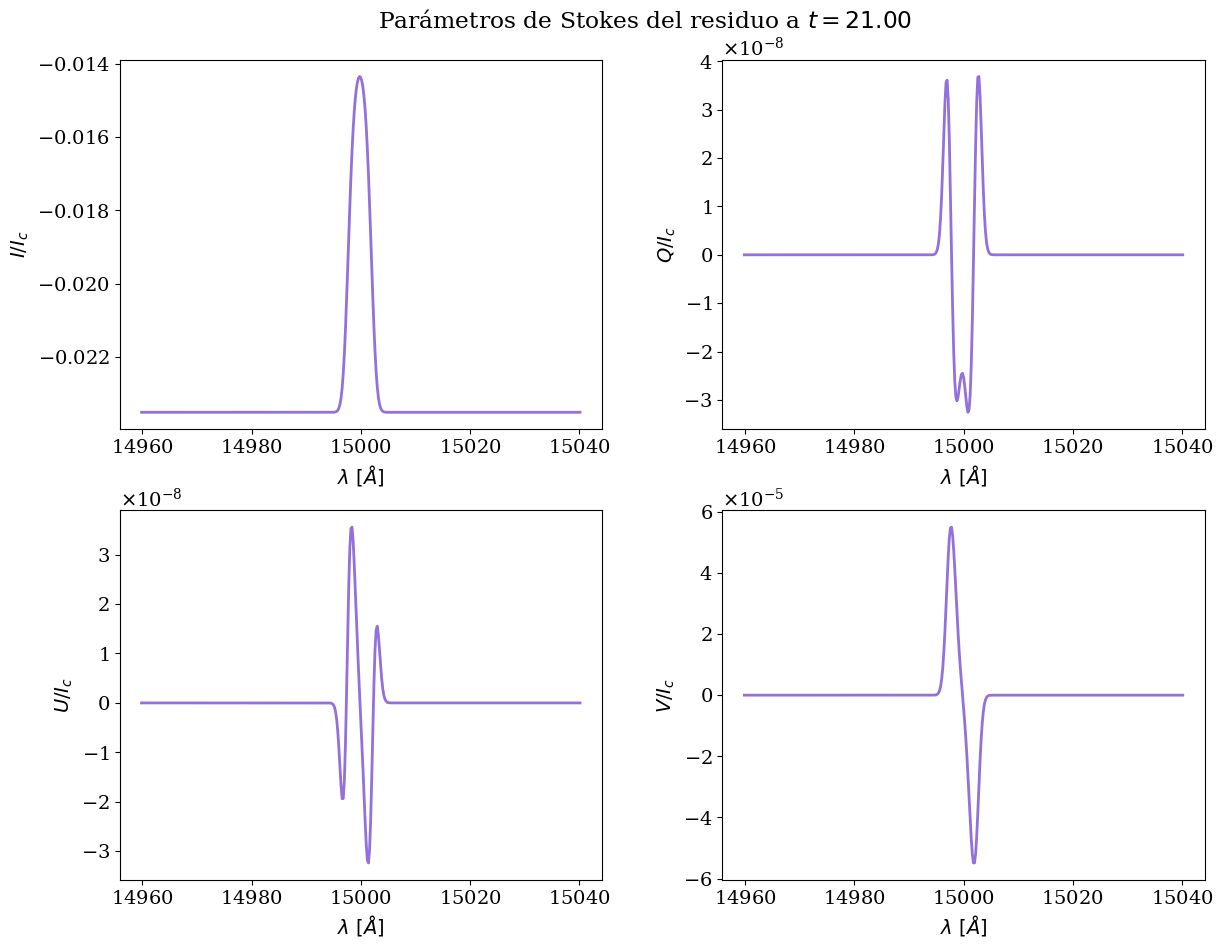

In [ ]:
#Plot de parámetros de Stokes del residuo a t = 21
plot(nrows=2, ncols=2, x=wave, y=R[21], mrk='-', xlabels=xlabels, ylabels=ylabels,\
           title=r'Parámetros de Stokes del residuo a $t = 21.00$', name='res');

In [ ]:
#Animación de parámetros de Stokes del residuo
anima(dt_show=1, nt=nt, x=wave, y=R, ylim=(1.1, 1.05), xlabels=xlabels, ylabels=ylabels, \
               title='Evolución de los parámetros de Stokes del residuo', name = 'Stokes_res')

In [ ]:
#Mostrar animación
mp4 = open('Stokes_res.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 height=650 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Parte 2

In [ ]:
#Índices del pico de la mancha en el tiempo
mancha = np.argmax(R[:, 0, :], axis=1)

In [ ]:
#Longitud de onda en reposo del pico de la mancha
lambda_0 = 15000 #[AA]

#Velocidad de la luz
c = 3e5 #[km/s]

#Desplazamiento Doppler del pico de la mancha en el tiempo
dlambda = wave[mancha] - lambda_0 #[AA]

#Velocidad en LOS de la mancha en el tiempo
vLOS = c * dlambda/lambda_0 #[km/s]

In [ ]:
#Periodo de rotación de la estrella
T = nt - 1

#Array de tiempo
t = np.linspace(0, T, nt)

#Fase de rotación completa de la mancha
fase = t/T

In [ ]:
#Índices del pico de la mancha en el tiempo con valores distintos de 0 (correspondientes a cara visible)
index = np.where(mancha != 0)[0]
index = index[1:-1]

#Velocidad en la LOS para cara visible
vLOS = vLOS[index]

#Fase para cara visible
fase = fase[index]

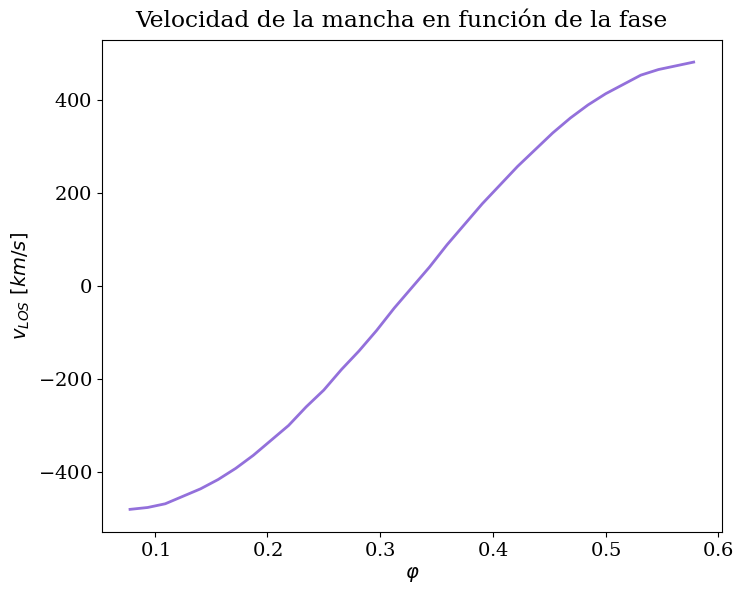

In [ ]:
#Plot de velocidad en la LOS frente a la fase
xlabel = r'$\varphi$'
ylabel = r'$v_{LOS} \ [km/s]$'

plot(nrows=1, ncols=1, x=fase, y=vLOS, mrk='-', xlabels=xlabel, ylabels=ylabel,\
           title='Velocidad de la mancha en función de la fase', name='fase_vLOS')

In [ ]:
#Fase de la mancha cuando está en el meridiano central
fase_0 = fase[16]
print(f'La fase de la mancha cuando está en el meridiano central es de {2*np.pi*fase_0:.2f} [rad]')

#Expresión analítica de la velocidad en la LOS
def vLOS_modelo(fase, latitud):
  #Velocidad de rotación de la estrella
  v_rot = 500 #[km/s]

  #Ángulo del eje de rotación con respecto a la LOS
  i = np.pi/2 #[rad]

  vLOS = v_rot * np.cos(latitud) * np.sin(i) * np.sin(2*np.pi*(fase - fase_0)) #[km/s]
  return vLOS

La fase de la mancha cuando está en el meridiano central es de 2.06 [rad]


In [ ]:
#Ajuste a la expresión analítica de la velocidad en la LOS
vLOS_coeff,_ = curve_fit(vLOS_modelo, fase, vLOS, p0 = np.pi/2)

#Latitud de la mancha
latitud = vLOS_coeff[0] * 180/np.pi #[grados]
print(f'La mancha se encuentra a una latitud de {latitud:.2f}º')

#Velocidad teórica en la LOS
vLOS_analitic = vLOS_modelo(fase, vLOS_coeff) #[km/s]

La mancha se encuentra a una latitud de 18.88º


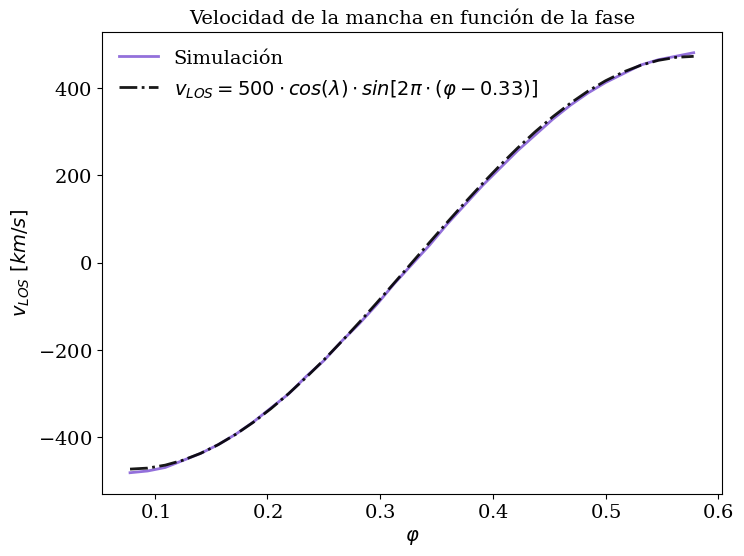

In [ ]:
#Plot de velocidad en la LOS frente a la fase junto con el ajuste a la expresión analítica
f = plt.figure(figsize=(8, 6))
plt.plot(fase, vLOS, '-', color='mediumpurple', lw=2, label = 'Simulación')
plt.plot(fase, vLOS_analitic, '-.', color = 'black', lw=2, alpha = 0.9, label = r'$v_{LOS} = 500\cdot cos(\lambda) \cdot sin[2\pi\cdot (\varphi - 0.33)]$')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(loc = 'upper left', frameon = False)

plt.title('Velocidad de la mancha en función de la fase')
plt.savefig('vLOS_ajuste' + '.png', format = 'png')
plt.show()

In [ ]:
#Velocidad en la LOS de posiciones centrales (cercanas al meridiano central)
vLOS_central = vLOS[(fase > 0.25) & (fase < 0.45)]

#Fase de posiciones centrales
fase_central = fase[(fase > 0.25) & (fase < 0.45)]

In [ ]:
#Pendiente y ordenada en el origen del ajuste a una recta de las velocidades en la LOS y fases de posiciones centrales
m, b = np.polyfit(fase_central, vLOS_central, 1)
print(f'La pendiente de la recta es m = {m:.2f} km/s')
print(f'La ordena en el origen de la recta es b = {b:.2f} km/s')

#Velocidad en la LOS mediante ajuste a una recta
vLOS_recta = m * fase_central + b #[km/s]

La pendiente de la recta es m = 2808.97 km/s
La ordena en el origen de la recta es b = -926.35 km/s


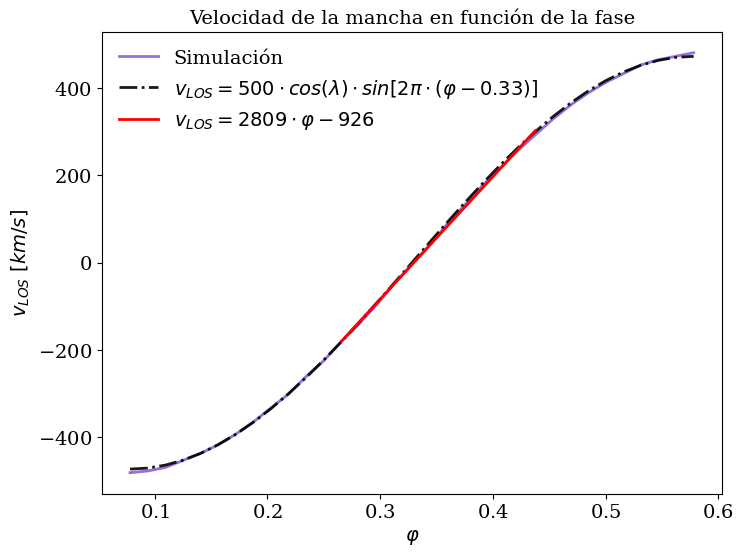

In [ ]:
#Plot de velocidad en la LOS frente a la fase junto con los ajustes
f = plt.figure(figsize=(8, 6))
plt.plot(fase, vLOS, '-', color='mediumpurple', lw=2, label = 'Simulación')
plt.plot(fase, vLOS_analitic, '-.', color = 'black', lw=2, alpha = 0.9, label = r'$v_{LOS} = 500\cdot cos(\lambda) \cdot sin[2\pi\cdot (\varphi - 0.33)]$')
plt.plot(fase_central, vLOS_recta, '-', color = 'red', lw=2, label=r'$v_{LOS} = 2809\cdot \varphi -926$')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(loc = 'upper left', frameon = False)

plt.title('Velocidad de la mancha en función de la fase')
plt.savefig('vLOS_ajuste_recta' + '.png', format = 'png')
plt.show()

In [ ]:
#Error cuadrático medio
MSE = np.mean((vLOS_central - vLOS_recta) ** 2) #[(km/s)²]
print(f'El error cuadrático medio es {MSE:.2f} (km/s)²')

#Error absoluto medio
MAE = np.mean(np.abs(vLOS_central - vLOS_recta)) #[km/s]
print(f'El error absoluto medio es {MAE:.2f} km/s')

#Error máximo absoluto
max_error = np.max(np.abs(vLOS_central  - vLOS_recta)) #[km/s]
print(f'El error máximo absoluto es {max_error:.2f} km/s')

El error cuadrático medio es 18.43 (km/s)²
El error absoluto medio es 3.32 km/s
El error máximo absoluto es 9.72 km/s


# Funciones para campo magnético y ángulos

In [ ]:
#Función para calcular la componente paralela de B
def B_parallel_cal(V_obs, dI_dlambda, C, g_eff, lambda_0):
    B_parallel = np.sqrt(- np.sum(V_obs * dI_dlambda)/(C * g_eff * (lambda_0**2) * np.sum(dI_dlambda**2)))
    return B_parallel

# Función para calcular la componente perpendicular de B
def B_perp_cal(Q_obs, U_obs, d2I_dlambda2, C, g_eff, lambda_0, phi):
    B_perp_cuadrado = - np.sum((Q_obs * np.cos(2*phi) + U_obs * np.sin(2*phi)) * d2I_dlambda2)/((C**2 / 4) * (g_eff**2) * (lambda_0**4) * np.sum(d2I_dlambda2**2))
    B_perp = np.sqrt(B_perp_cuadrado)
    return B_perp
# Función para calcular el azimuth en el plano del cielo
def phi_cal(Q_obs, U_obs, d2I_dlambda2):
    phi = 0.5 * np.arctan(np.sum(U_obs * d2I_dlambda2)/np.sum(Q_obs * d2I_dlambda2))
    return phi

In [ ]:
#Función para calcular derivadas de la intensidad respecto a la longitud de onda
def derivadas(I, wave):
  #Derivada primera de la intensidad respecto a la longitud de onda
  dI_dlambda = np.gradient(I, wave)
  #Derivada segunda de la intensidad respecto a la longitud de onda
  d2I_dlambda2 = np.gradient(dI_dlambda, wave)
  return dI_dlambda, d2I_dlambda2

In [ ]:
#Función para calcular el módulo del campo magnético y su inclinación
def campo(B_perp, B_parallel):
  #Módulo del campo magnético
  B = np.sqrt(B_parallel**2 + B_perp**2)
  #Inclinación del campo
  theta = np.arctan(B_perp/B_parallel)
  return B, theta

# Parte 3

In [ ]:
#Logitudes de onda del pico de la mancha en el tiempo para la cara visible
lambda_mancha = wave[mancha][index] #[AA]

In [ ]:
#Arrays para los parámetros de Stokes en el tiempo del pico de la mancha
I_mancha = np.empty(nt)
Q_obs_mancha = np.empty(nt)
U_obs_mancha = np.empty(nt)
V_obs_mancha = np.empty(nt)

In [ ]:
#Añade los parámetros de Stokes en el tiempo del pico de la mancha a sus respectivas arrays
for j in range(nt):
  I_mancha[j] = R[j, 0, mancha[j]]
  Q_obs_mancha[j] = R[j, 1, mancha[j]]
  U_obs_mancha[j] = R[j, 2, mancha[j]]
  V_obs_mancha[j] = R[j, 3, mancha[j]]

In [ ]:
#Parámetros de Stokes en el tiempo del pico de la mancha para la cara visible
I_mancha = I_mancha[index]
Q_obs_mancha = Q_obs_mancha[index]
U_obs_mancha = U_obs_mancha[index]
V_obs_mancha = V_obs_mancha[index]

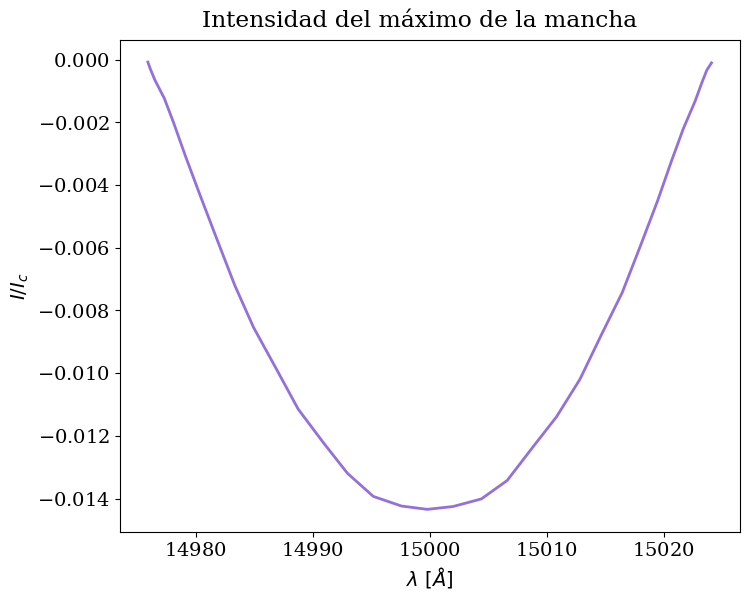

In [ ]:
#Plot de parámetros de Stokes del espectro no perturbado
xlabel = r'$\lambda \ [\AA]$'
ylabel = r'$I/I_c$'

plot(nrows=1, ncols=1, x=lambda_mancha, y=I_mancha, mrk='-', xlabels=xlabel, ylabels=ylabel,\
           title=r'Intensidad del máximo de la mancha', name='I_mancha');

In [ ]:
#Derivadas de la intensidad de la mancha respecto a la longitud de onda
dI_dlambda, d2I_dlambda2 = derivadas(I_mancha, lambda_mancha)

In [ ]:
#Factor de Landé efectivo
g_eff = 1

#Constante
C = 4.67 * 10**(-13) #[AA^(-1) G^(-1)]

In [ ]:
#Azimuth en el plano del cielo
phi = phi_cal(Q_obs_mancha, U_obs_mancha, d2I_dlambda2) #[rad]
print(f'φ = {phi*180/np.pi:.2f}º')

#Componente perpendicular del campo magnético
B_perp = B_perp_cal(Q_obs_mancha, U_obs_mancha, d2I_dlambda2, C, g_eff, lambda_0, phi) #[G]
print(f'B⊥ = {B_perp:.2f} G')

#Componente paralela del campo magnético
B_parallel = B_parallel_cal(V_obs_mancha, dI_dlambda, C, g_eff, lambda_0) #[G]
print(f'B∥ = {B_parallel:.2f} G')

#Módulo e inclinación del campo magnético
B, theta = campo(B_perp, B_parallel) #[G], [rad]
print(f'B = {B:.2f} G')
print(f'θ = {theta*180/np.pi:.2f}º')

φ = -27.96º
B⊥ = 351.83 G
B∥ = 4.31 G
B = 351.85 G
θ = 89.30º


- Seeing constante

In [8]:
#Intensidad del continuo a t = 0
Ic_s = Stokes[0, 0, 0]

In [ ]:
#Función para normalizar al continuo los parámetros de Stokes en el tiempo del pico de la mancha
def normalizar(Ic, I, Q, U, V):
  I_norm = I/Ic
  Q_norm = Q/Ic
  U_norm = U/Ic
  V_norm = V/Ic

  return I_norm, Q_norm, U_norm, V_norm

In [ ]:
#Parámetros de Stokes en el tiempo del pico de la mancha normalizados para la cara visible
I_norm_s, Q_norm_s, U_norm_s, V_norm_s = normalizar(Ic_s, I_mancha, Q_obs_mancha, U_obs_mancha, V_obs_mancha)

In [ ]:
#Derivadas de la intensidad de la mancha normalizada respecto a la longitud de onda
dI_dlambda_norm_s, d2I_dlambda2_norm_s =  derivadas(I_norm_s, lambda_mancha)

In [ ]:
#Azimuth en el plano del cielo
phi_norm_s = phi_cal(Q_norm_s, U_norm_s, d2I_dlambda2_norm_s) #[rad]
print('Normalizando al continuo con seeing estable: ')
print(f'φ = {phi_norm_s*180/np.pi:.2f}º')

#Componente perpendicular del campo magnético
B_perp_norm_s = B_perp_cal(Q_norm_s, U_norm_s, d2I_dlambda2_norm_s, C, g_eff, lambda_0, phi_norm_s) #[G]
print(f'B⊥ = {B_perp_norm_s:.2f} G')

#Componente paralela del campo magnético
B_parallel_norm_s = B_parallel_cal(V_norm_s, dI_dlambda_norm_s, C, g_eff, lambda_0) #[G]
print(f'B∥ = {B_parallel_norm_s:.2f} G')

#Módulo e inclinación del campo magnético
B_norm_s, theta_norm_s = campo(B_perp_norm_s, B_parallel_norm_s) #[G], [rad]
print(f'B = {B_norm_s:.2f} G')
print(f'θ = {theta_norm_s*180/np.pi:.2f}º')

Normalizando al continuo con seeing estable: 
φ = -27.96º
B⊥ = 351.83 G
B∥ = 4.31 G
B = 351.85 G
θ = 89.30º


- Seeing no constante

In [ ]:
#Intensidad del continuo en el tiempo
Ic_v = Stokes[:, 0, 0][index]

In [ ]:
#Parámetros de Stokes en el tiempo del pico de la mancha normalizados para la cara visible
I_norm_v, Q_norm_v, U_norm_v, V_norm_v = normalizar(Ic_v, I_mancha, Q_obs_mancha, U_obs_mancha, V_obs_mancha)

In [ ]:
#Derivadas de la intensidad de la mancha normalizada respecto a la longitud de onda
dI_dlambda_norm_v, d2I_dlambda2_norm_v = derivadas(I_norm_v, lambda_mancha)

In [ ]:
#Azimuth en el plano del cielo
phi_norm_v = phi_cal(Q_norm_v, U_norm_v, d2I_dlambda2_norm_v) #[rad]
print('Normalizando al continuo con seeing variable: ')
print(f'φ = {phi_norm_v*180/np.pi:.2f}º')

#Componente perpendicular del campo magnético
B_perp_norm_v = B_perp_cal(Q_norm_v, U_norm_v, d2I_dlambda2_norm_v, C, g_eff, lambda_0, phi_norm_v) #[G]
print(f'B⊥ = {B_perp_norm_v:.2f} G')

#Componente paralela del campo magnético
B_parallel_norm_v = B_parallel_cal(V_norm_v, dI_dlambda_norm_v, C, g_eff, lambda_0) #[G]
print(f'B∥ = {B_parallel_norm_v:.2f} G')

#Módulo e inclinación del campo magnético
B_norm_v, theta_norm_v = campo(B_perp_norm_v, B_parallel_norm_v) #[G], [rad]
print(f'B = {B_norm_v:.2f} G')
print(f'θ = {theta_norm_v*180/np.pi:.2f}º')

Normalizando al continuo con seeing variable: 
φ = -26.15º
B⊥ = 358.05 G
B∥ = 4.32 G
B = 358.07 G
θ = 89.31º
